In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()


In [22]:
from torchvision import datasets, transforms
from torch.utils.data import random_split

dataset_path = '/Users/saibhargavmandava/Documents/bhushanGit/TransferLearning-PyTorch-/caltech_data[Resnet]/caltech-101'

# 1️⃣ Apply only basic transformations before splitting
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 2️⃣ Load dataset properly using ImageFolder
dataset = datasets.ImageFolder(root=dataset_path, transform=basic_transform)
class_names = dataset.classes#getting all the class names
# 3️⃣ Compute split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # Remaining 20%

# 4️⃣ Perform the correct split
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Check the sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"class names: {dataset.classes}")


Training set size: 7315
Validation set size: 1829
class names: ['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone'

In [ ]:
train_dataset.dataset.transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_dataset.dataset.transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [24]:
device  = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else 'cpu'
print(f"using device {device}")

using device mps


In [18]:
train_loader =torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader =torch.utils.data.DataLoader(val_dataset , batch_size=4, shuffle=True, num_workers=4)

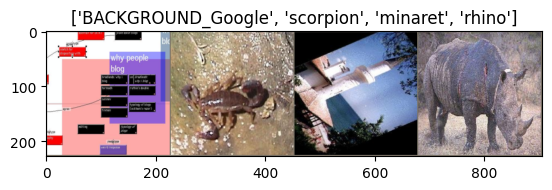

In [23]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp =inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std= np.array([0.229, 0.224, 0.225])
    inp =std*inp+mean
    inp =np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [35]:
import time
import os
import torch
from tempfile import TemporaryDirectory

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, train_dataset, val_dataset, num_epochs=25):
    # Use MPS if available, otherwise fall back to CUDA or CPU
    device = torch.device("mps") if torch.backends.mps.is_available() else \
             torch.device("cuda") if torch.cuda.is_available() else \
             torch.device("cpu")

    print(f"Using device: {device}")

    model = model.to(device)  # Move model to the selected device
    
    since = time.time()
    
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)  # Save initial model parameters
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs-1}')
            print('-' * 100)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                    dataloader, dataset = train_loader, train_dataset
                else:
                    model.eval()  # Set model to evaluation mode
                    dataloader, dataset = val_loader, val_dataset

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataset)
                epoch_acc = running_corrects.float() / len(dataset)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Step the scheduler **after** the training phase
                if phase == 'train':
                    scheduler.step()

                # Save best model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        # Load the best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    return model


In [26]:
def visuvalize_model(model, num_images=6):  
    was_training =model.training
    model.eval()
    images_so_far =0
    fig =plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs =inputs.to(device)
            labels =labels.to(device)
            outputs =model(inputs)
            _, preds =torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax =plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

In [27]:
model_ft =models.resnet18(weights = 'IMAGENET1K_V1')
num_ftrs =model_ft.fc.in_features
model_ft.fc =nn.Linear(num_ftrs, len(class_names))
model_ft =model_ft.to(device)
criterion =nn.CrossEntropyLoss()
optimizer_ft =optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler =lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [37]:
model_ft = train_model(
    model_ft, 
    criterion, 
    optimizer_ft, 
    exp_lr_scheduler, 
    train_loader,  # ✅ Pass training data loader
    val_loader,    # ✅ Pass validation data loader
    train_dataset, # ✅ Pass training dataset
    val_dataset,   # ✅ Pass validation dataset
    num_epochs=25
)


Using device: mps
Epoch 0/24
----------------------------------------------------------------------------------------------------
train Loss: 4.5618 Acc: 0.0923
val Loss: 4.6311 Acc: 0.0962
Epoch 1/24
----------------------------------------------------------------------------------------------------
train Loss: 4.5592 Acc: 0.0941
val Loss: 4.6419 Acc: 0.0908
Epoch 2/24
----------------------------------------------------------------------------------------------------
train Loss: 4.5588 Acc: 0.0928
val Loss: 4.6344 Acc: 0.0940
Epoch 3/24
----------------------------------------------------------------------------------------------------
train Loss: 4.5647 Acc: 0.0945
val Loss: 4.6612 Acc: 0.0847
Epoch 4/24
----------------------------------------------------------------------------------------------------
train Loss: 4.5620 Acc: 0.0900
val Loss: 4.6652 Acc: 0.0847
Epoch 5/24
----------------------------------------------------------------------------------------------------
train Loss

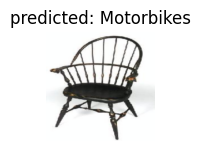

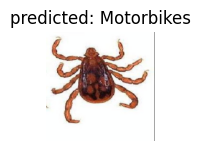

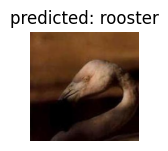

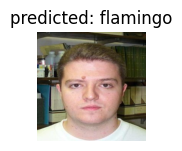

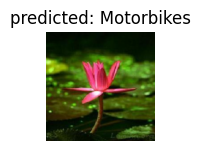

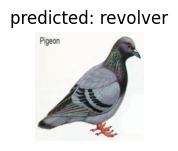

In [39]:
visuvalize_model(model_ft)


In [40]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(
    model_conv, 
    criterion, 
    optimizer_ft, 
    exp_lr_scheduler, 
    train_loader,  # ✅ Pass training data loader
    val_loader,    # ✅ Pass validation data loader
    train_dataset, # ✅ Pass training dataset
    val_dataset,   # ✅ Pass validation dataset
    num_epochs=25
)


Using device: mps
Epoch 0/24
----------------------------------------------------------------------------------------------------
train Loss: 0.0917 Acc: 0.0506


/Users/saibhargavmandava/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


val Loss: 0.0817 Acc: 0.0525
Epoch 1/24
----------------------------------------------------------------------------------------------------
